In [ ]:
location_coords = {
    "home": (200,460),
    "bank": (760, 250),
    "resturant": (780, 50),
    "hospital": (280, 240)
}

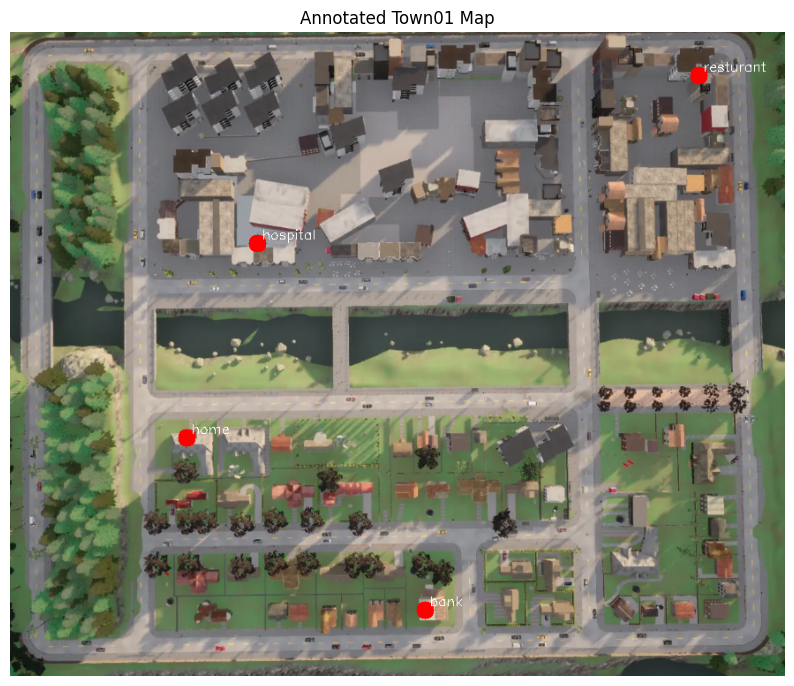

In [2]:
import cv2
import matplotlib.pyplot as plt

# === STEP 1: Load the Map Image ===
img_path = "Town01_map.png"
map_img = cv2.imread(img_path)

# === STEP 2: Define Landmark Locations on the Map ===
location_coords = {
    "home": (200,460),
    "bank": (470, 655),
    "resturant": (780, 50),
    "hospital": (280, 240)
}

# === STEP 3: Draw Landmarks on the Map ===
for name, coord in location_coords.items():
    cv2.circle(map_img, coord, 10, (0, 0, 255), -1)
    cv2.putText(map_img, name, (coord[0]+5, coord[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

# Show it
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(map_img, cv2.COLOR_BGR2RGB))
plt.title("Annotated Town01 Map")
plt.axis("off")
plt.show()


/home/elahed/anaconda3/envs/dt_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔍 Prompt matched to location: bank


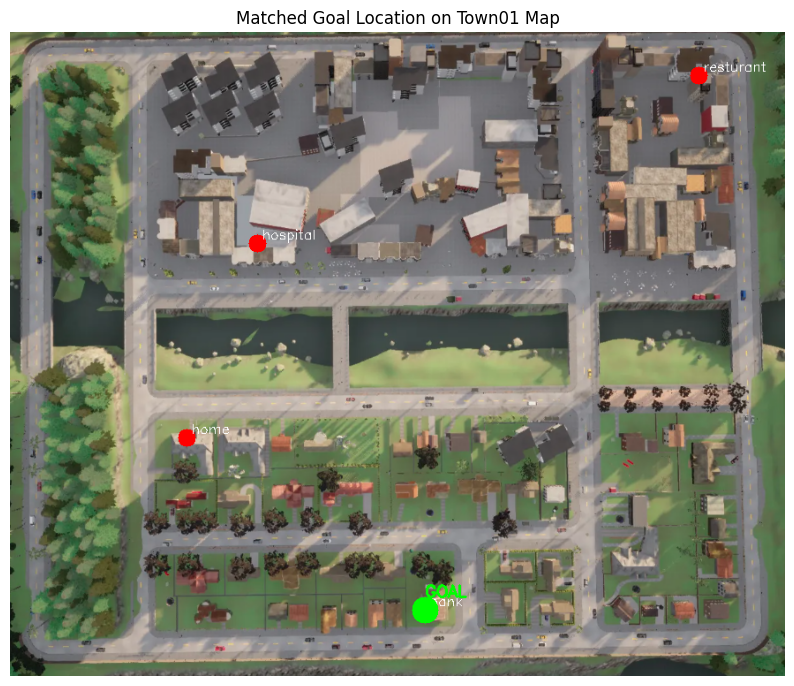

In [5]:
import cv2
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# === STEP 1: Load the Map Image ===
map_img = cv2.imread("Town01_map.png")

# === STEP 2: Define Landmark Locations on the Map ===
location_coords = {
    "home": (200,460),
    "bank": (470, 655),
    "resturant": (780, 50),
    "hospital": (280, 240)
}
location_names = list(location_coords.keys())

# === STEP 3: Draw Landmarks on the Map ===
for name, coord in location_coords.items():
    cv2.circle(map_img, coord, 10, (0, 0, 255), -1)
    cv2.putText(map_img, name, (coord[0]+5, coord[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

# === STEP 4: Load Fast English-only Model ===
model = SentenceTransformer('all-MiniLM-L6-v2')  # Very fast, English only

# === STEP 5: Encode Landmarks and Prompt ===
landmark_embeddings = model.encode(location_names)
prompt = "Take me to the bank"
prompt_embedding = model.encode([prompt])

# === STEP 6: Find Closest Matching Location ===
scores = cosine_similarity(prompt_embedding, landmark_embeddings)
matched_idx = scores.argmax()
matched_location = location_names[matched_idx]

print(f"🔍 Prompt matched to location: {matched_location}")

# === STEP 7: Draw Goal Marker ===
cv2.circle(map_img, location_coords[matched_location], 15, (0, 255, 0), -1)
cv2.putText(map_img, "GOAL", (location_coords[matched_location][0], location_coords[matched_location][1]-15),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# === STEP 8: Show the Map ===
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(map_img, cv2.COLOR_BGR2RGB))
plt.title("Matched Goal Location on Town01 Map")
plt.axis("off")
plt.show()


In [2]:
import carla
import sys
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Add agents path (adjust to your CARLA path)
sys.path.append('/home/elahed/users/elahe/CARLA/CARLA_0.9.15/PythonAPI/carla')
from agents.navigation.behavior_agent import BehaviorAgent

# === Map scale setup ===
def pixel_to_world(x_img, y_img, map_size_px=1024, map_size_m=300):
    meters_per_pixel = map_size_m / map_size_px
    x_world = (x_img - map_size_px / 2) * meters_per_pixel
    y_world = -(y_img - map_size_px / 2) * meters_per_pixel
    return carla.Location(x=x_world, y=y_world, z=0.0)

# === Connect to CARLA ===
client = carla.Client("localhost", 2000)
client.set_timeout(5.0)
world = client.get_world()
carla_map = world.get_map()

# === Define landmark pixels on Town01 map ===
location_coords = {
    "home": (160, 670),
    "bank": (740, 260),
    "hospital": (370, 200)
}

# === Prompt → Embedding → Match to landmark ===
model = SentenceTransformer('all-MiniLM-L6-v2')
locations = list(location_coords.keys())
landmark_embeddings = model.encode(locations)
prompt = "Take me to the bank"
prompt_embedding = model.encode([prompt])
scores = cosine_similarity(prompt_embedding, landmark_embeddings)
matched_idx = scores.argmax()
matched_location_name = locations[matched_idx]
matched_pixel = location_coords[matched_location_name]

# === Get goal waypoint ===
goal_location = pixel_to_world(*matched_pixel)
goal_wp = carla_map.get_waypoint(goal_location, project_to_road=True, lane_type=carla.LaneType.Driving)

# === Get spawn point and create agent ===
spawn_transform = carla_map.get_spawn_points()[0]
vehicle_bp = world.get_blueprint_library().filter('vehicle.*model3*')[0]
vehicle = world.try_spawn_actor(vehicle_bp, spawn_transform)

# Make sure vehicle is spawned
if vehicle is None:
    raise RuntimeError("Vehicle could not be spawned at spawn point 0")

agent = BehaviorAgent(vehicle)

# === Plan route using agent ===
origin = vehicle.get_location()
#route = agent._trace_route(origin, goal_wp.transform.location)  # returns (waypoint, road_option)
agent.set_destination(goal_wp.transform.location)
route = agent._local_planner.get_plan()


# === Extract subtasks ===
subtasks = []
for wp, road_option in route:
    if road_option == carla.RoadOption.LEFT:
        label = "left_turn"
    elif road_option == carla.RoadOption.RIGHT:
        label = "right_turn"
    elif road_option == carla.RoadOption.STRAIGHT:
        label = "lane_follow"
    elif road_option in [carla.RoadOption.CHANGELANELEFT, carla.RoadOption.CHANGELANERIGHT]:
        label = "merge"
    else:
        label = "lane_follow"
    loc = wp.transform.location
    subtasks.append((label, (loc.x, loc.y)))

# === Print result ===
print("Subtasks:")
for sub in subtasks[:10]:  # just show first 10 for now
    print(sub)


AttributeError: module 'carla' has no attribute 'RoadOption'

In [3]:
print(route)

deque([(<carla.libcarla.Waypoint object at 0x7f7aa40e4510>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f7aa40e4580>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f7aa40e45f0>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f7aa40e4660>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f7aa40e46d0>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f7aa40e4740>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f7aa40e47b0>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f7aa40e4820>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f7aa40e4890>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f7aa40e4900>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f7aa40e4970>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f7aa40e49e0>, <RoadOption.LANEFOLLOW: 4>), (<carla.l

/home/elahed/anaconda3/envs/dt_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔍 Prompt matched to location: bank


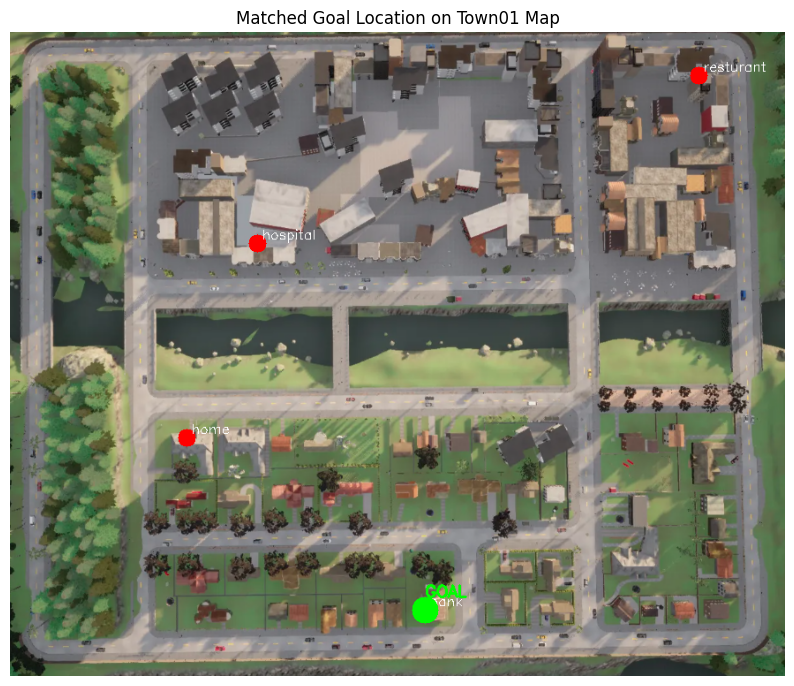

In [1]:
import cv2
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# === STEP 1: Load the Map Image ===
map_img = cv2.imread("Town01_map.png")

# === STEP 2: Define Landmark Locations on the Map ===
location_coords = {
    "home": (200,460),
    "bank": (470, 655),
    "resturant": (780, 50),
    "hospital": (280, 240)
}
location_names = list(location_coords.keys())

# === STEP 3: Draw Landmarks on the Map ===
for name, coord in location_coords.items():
    cv2.circle(map_img, coord, 10, (0, 0, 255), -1)
    cv2.putText(map_img, name, (coord[0]+5, coord[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

# === STEP 4: Load Fast English-only Model ===
model = SentenceTransformer('all-MiniLM-L6-v2')  # Very fast, English only

# === STEP 5: Encode Landmarks and Prompt ===
landmark_embeddings = model.encode(location_names)
prompt = "Take me to the bank"
prompt_embedding = model.encode([prompt])

# === STEP 6: Find Closest Matching Location ===
scores = cosine_similarity(prompt_embedding, landmark_embeddings)
matched_idx = scores.argmax()
matched_location = location_names[matched_idx]

print(f"🔍 Prompt matched to location: {matched_location}")

# === STEP 7: Draw Goal Marker ===
cv2.circle(map_img, location_coords[matched_location], 15, (0, 255, 0), -1)
cv2.putText(map_img, "GOAL", (location_coords[matched_location][0], location_coords[matched_location][1]-15),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# === STEP 8: Show the Map ===
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(map_img, cv2.COLOR_BGR2RGB))
plt.title("Matched Goal Location on Town01 Map")
plt.axis("off")
plt.show()


In [2]:
map_size_px = 1024
map_size_m = 300  # meters across Town01 map

def pixel_to_world(x_img, y_img):
    meters_per_pixel = map_size_m / map_size_px
    x_world = (x_img - map_size_px / 2) * meters_per_pixel
    y_world = -(y_img - map_size_px / 2) * meters_per_pixel
    return carla.Location(x=x_world, y=y_world, z=0.0)

def world_to_pixel(x_world, y_world):
    meters_per_pixel = map_size_m / map_size_px
    x_img = int((x_world / meters_per_pixel) + map_size_px / 2)
    y_img = int((-y_world / meters_per_pixel) + map_size_px / 2)
    return x_img, y_img


In [3]:
import carla
import sys

sys.path.append('/home/elahed/users/elahe/CARLA/CARLA_0.9.15/PythonAPI/carla')  # Adjust if needed
from agents.navigation.behavior_agent import BehaviorAgent
from agents.navigation.local_planner import RoadOption

client = carla.Client("localhost", 2000)
client.set_timeout(10.0)
world = client.get_world()
carla_map = world.get_map()


In [4]:
# Get spawn transform (or current vehicle location)
spawn = carla_map.get_spawn_points()[0]  # or use vehicle.get_transform()
vehicle = world.spawn_actor(world.get_blueprint_library().filter("vehicle.tesla.model3")[0], spawn)
agent = BehaviorAgent(vehicle)

# Convert goal pixel to world → get waypoint
goal_pixel = location_coords[matched_location]
goal_world = pixel_to_world(*goal_pixel)
goal_wp = carla_map.get_waypoint(goal_world, project_to_road=True, lane_type=carla.LaneType.Driving)

# Set destination
agent.set_destination(goal_wp.transform.location)

# Get planned route
route = agent._local_planner.get_plan()  # [(waypoint, road_option)]


In [6]:
print(route)

deque([(<carla.libcarla.Waypoint object at 0x7f89a01dd620>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f89a01dd690>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f89a01dd700>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f89a01dd770>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f89a01dd7e0>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f89a01dd850>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f89a01dd8c0>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f89a01dd930>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f89a01dd9a0>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f89a01dda10>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f89a01dda80>, <RoadOption.LANEFOLLOW: 4>), (<carla.libcarla.Waypoint object at 0x7f89a01ddaf0>, <RoadOption.LANEFOLLOW: 4>), (<carla.l

In [5]:
for wp, _ in route:
    x_world, y_world = wp.transform.location.x, wp.transform.location.y
    px, py = world_to_pixel(x_world, y_world)
    cv2.circle(map_img, (px, py), 2, (255, 0, 0), -1)  # Blue route
